

In the previous lab, we explored unsupervised learning using the widely applied **k-means clustering** algorithm.  

In this lab, we’ll shift our focus to **Principal Component Analysis (PCA)**—one of the most powerful and versatile techniques in unsupervised learning. PCA is best known for **reducing the dimensionality** of high-dimensional data, but it’s also widely used for **visualization, noise reduction, and feature extraction**.  

After learning the core ideas behind PCA, we’ll move on to a **guided practice**. Then, you’ll apply PCA to another dataset for your **quiz question** to check your understanding.


## Guided Practice: Using PCA for Image Compression


### Import Libraries
We'll use `numpy` for array operations, `matplotlib` for plotting, `imread` to load the image, and scikit-learn's `PCA` for dimensionality reduction.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread


from sklearn.decomposition import PCA

### Load and display the color image
The image is an array with shape `(H, W, 3)` for RGB. We print the shape and show the original image.

(1307, 960, 3)


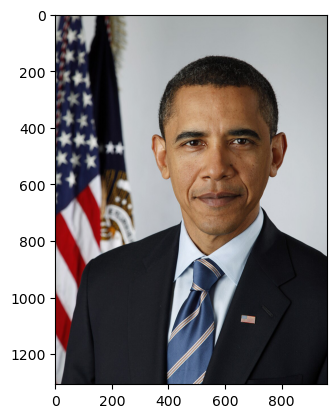

In [2]:
image_raw = imread("Official_portrait_of_Barack_Obama.jpg")
print(image_raw.shape)

plt.figure()
plt.imshow(image_raw);



### Convert to Grayscale for 2D PCA

PCA expects a 2D input of shape **(n_samples, n_features)**.  
For an image with shape **(height, width, 3)**, we need to reduce it to 2D.  
We'll **collapse the RGB channels into a single grayscale channel** by summing across the color dimension (axis=2).  
Then we'll **normalize the result to [0, 1]** by dividing by the maximum value.



In [3]:
# Collapse RGB to grayscale by summing across color channels (axis=2)
image_sum = image_raw.sum(axis=2)
print("Grayscale shape:", image_sum.shape)

Grayscale shape: (1307, 960)


In [4]:
# Normalize to the range [0, 1]
image_bw = image_sum / image_sum.max()
print("Maximum pixel value after normalization:", image_bw.max())

Maximum pixel value after normalization: 1.0


### Fit PCA on the Grayscale Matrix

Now that our grayscale image has shape **(H, W)** where each row is treated as a sample and each column as a feature, we can **fit PCA** to learn the principal components.


In [5]:
pca = PCA()
pca.fit(image_bw)

PCA()

**What `.fit()` Does:**

* **Centers the data** - Subtracts the mean of each column (feature) so the data is centered at the origin.  
* **Finds principal components** - Uses Singular Value Decomposition (SVD) to identify the directions of maximum variance.  
* **Stores results** - Saves the components, explained variance, and other related values in the `pca` object.  


**After Fitting, the `pca` Object Contains:**

- `pca.components_` - Principal component vectors (directions)  
- `pca.explained_variance_` - Variance captured by each component  
- `pca.explained_variance_ratio_` - Fraction of total variance explained by each component  
- `pca.mean_` - Mean of each feature (used for centering)



### Compute Explained Variance and Choose Optimal k

- `explained_variance_ratio_` provides the fraction of total variance explained by each component.
- We compute the cumulative sum to find the smallest `k` where cumulative variance ≥ 95%.



In [6]:
# Compute cumulative explained variance (in percentage)
var_cumu = np.cumsum(pca.explained_variance_ratio_) * 100

In [7]:
# Find the minimum k where cumulative variance >= 95%
k = np.argmax(var_cumu > 95)
print(f"Number of components explaining 95% variance: {k}")

Number of components explaining 95% variance: 24


### Visualize the Cumulative Variance Curve

We'll plot cumulative explained variance versus the number of components, with reference lines marking our chosen `k` and the 95% threshold.

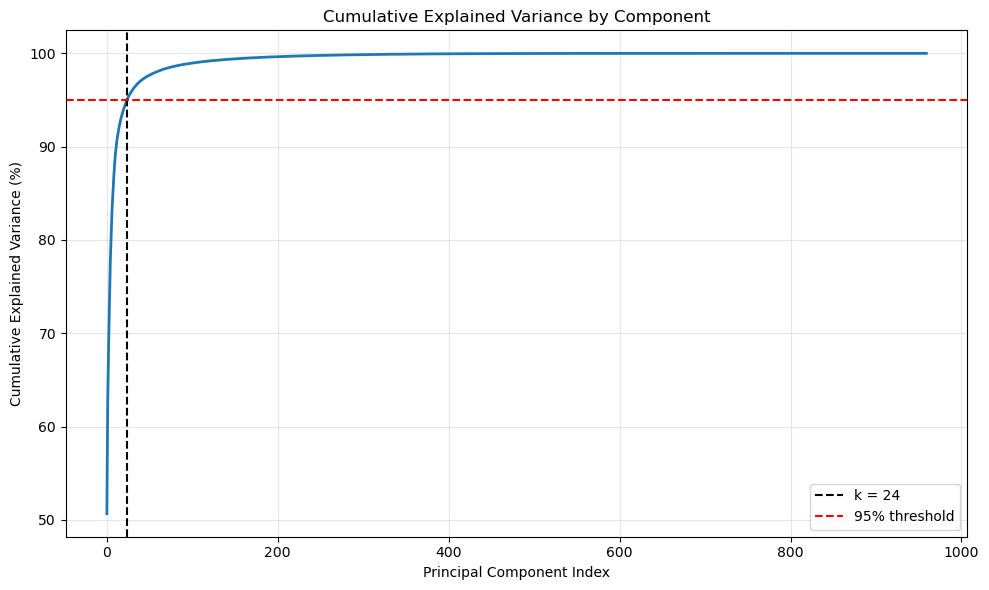

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(var_cumu, linewidth=2)
plt.axvline(x=k, color="k", linestyle="--", label=f'k = {k}')
plt.axhline(y=95, color="r", linestyle="--", label='95% threshold')
plt.xlabel('Principal Component Index')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Cumulative Explained Variance by Component')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
# Verify that the total number of PCA components matches the number of features (columns)
len(pca.components_)

960

### Reconstruct the Image with k Components

Now we'll create a new PCA model with exactly `k` components and use it to compress and reconstruct the image:

1. **Compression:** `fit_transform()` projects the image from **(H, W)** to **(H, k)**  
2. **Reconstruction:** `inverse_transform()` maps back from **(H, k)** to **(H, W)**

The reconstructed image uses only the top k principal components, resulting in lossy compression.

In [10]:
# Create PCA model with k components
k_pca = PCA(n_components=k)

# Compress: transform to k-dimensional space
image_compressed = k_pca.fit_transform(image_bw)
print(f"Compressed image shape: {image_compressed.shape}")

# Reconstruct: transform back to original dimensional space
image_recon = k_pca.inverse_transform(image_compressed)
print(f"Reconstructed image shape: {image_recon.shape}")

Compressed image shape: (1307, 24)
Reconstructed image shape: (1307, 960)


### Plot the Reconstructed Image

Since we use only k components instead of all W components, the reconstruction is lossy - it **loses some fine details** while **preserving the main structure and patterns**.

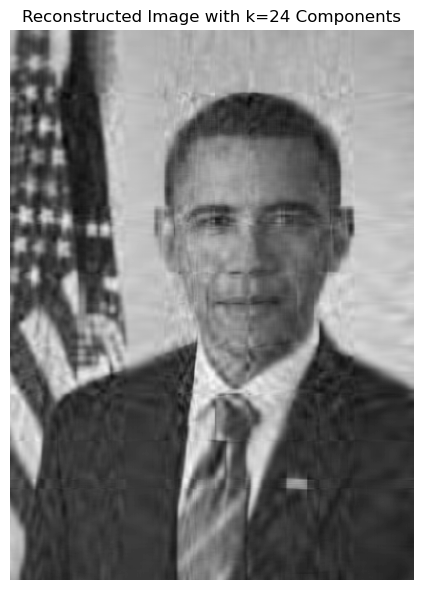

In [11]:
# Plot the reconstructed image
plt.figure(figsize=(8, 6))
plt.imshow(image_recon, cmap=plt.cm.gray)
plt.title(f'Reconstructed Image with k={k} Components')
plt.axis('off')
plt.tight_layout()
plt.show()

### Compare Reconstructions Across Different k Values

Reconstruction quality depends on **k**: higher k yields **better image quality** but **less compression**.  
Let's compare several values of k to observe the quality-compression tradeoff.

- The **2×3 grid** shows reconstructions for k in [10, 25, 50, 100, 150, 250].  
- Notice **blocky artifacts** at low k and **progressive detail recovery** as k increases.  
- Titles indicate the number of components; axes are hidden for clarity.  
- `constrained_layout=True` prevents subplot overlap.

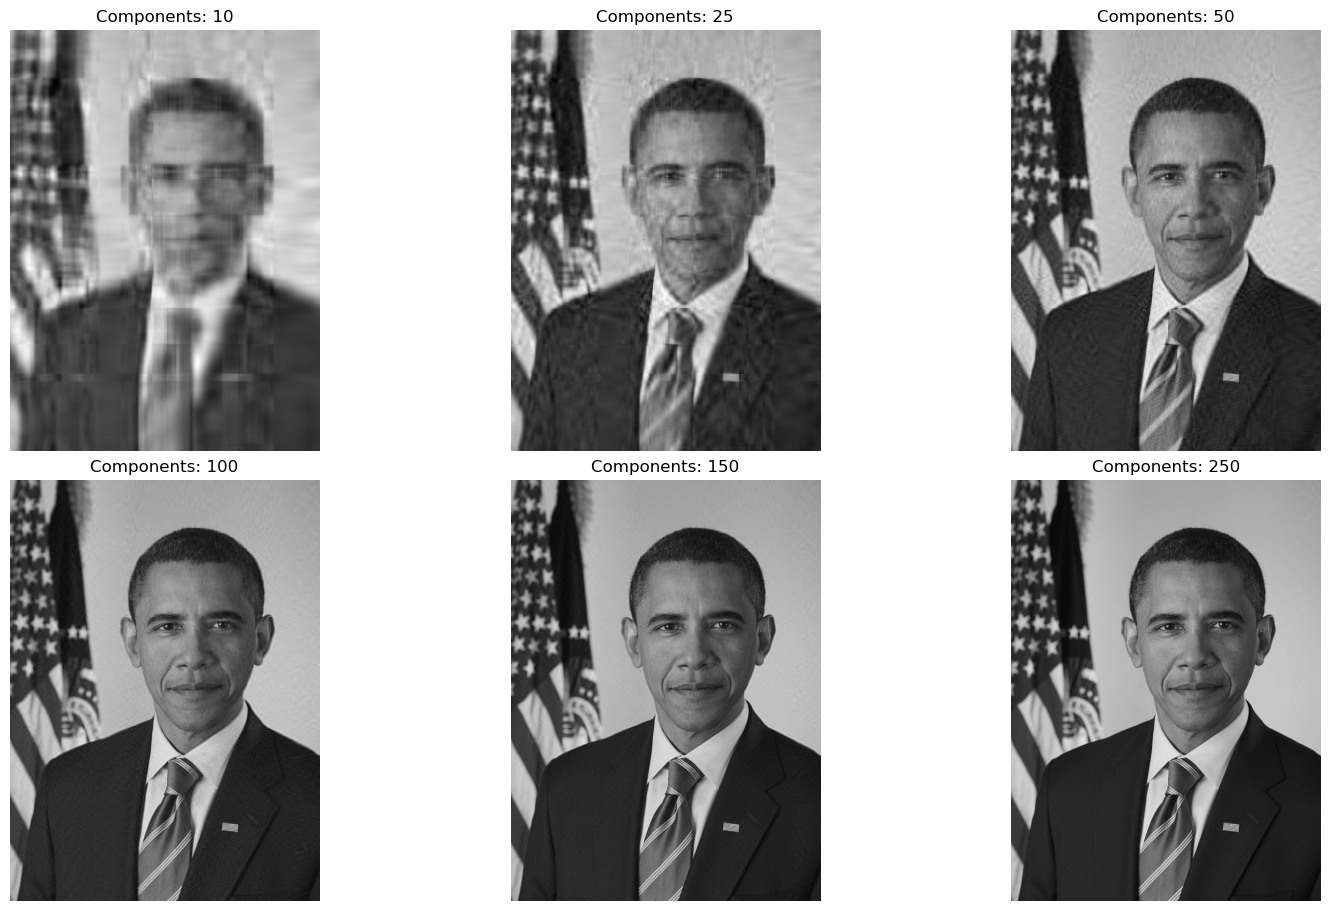

In [12]:
def plot_at_k(ax, k):
    kpca = PCA(n_components=k)
    image_recon = kpca.inverse_transform(kpca.fit_transform(image_bw))
    ax.imshow(image_recon, cmap=plt.cm.gray)
    ax.set_title(f"Components: {k}")
    ax.axis('off')

ks = [10, 25, 50, 100, 150, 250]

fig, axes = plt.subplots(2, 3, figsize=(15, 9), constrained_layout=True)

for ax, k_val in zip(axes.flat, ks):
    plot_at_k(ax, k_val)

plt.show()

### Observations: Reconstruction Quality vs Number of Components

As the number of principal components (k) increases, the reconstructed image becomes progressively clearer:

- **k = 10:** Heavily compressed, very blurry and blocky - most fine details are lost.  
- **k = 25-50:** Major facial features and structure emerge, but texture and sharpness remain limited.  
- **k = 100-150:** Much clearer reconstruction with most details recovered and only minor artifacts.  
- **k = 250:** Almost indistinguishable from the original image.  

Even though the original image has **960 dimensions (features)**, we achieve visually similar reconstruction using only a small fraction of components.  
This demonstrates PCA's power for **lossy compression** - preserving essential information while discarding redundant details.

In [13]:
# Get cumulative explained variance at k=250
k_250 = 250
cumulative_variance_250 = var_cumu[k_250 - 1]  # -1 because var_cumu is 0-indexed

print(f"Cumulative explained variance at k={k_250}: {cumulative_variance_250:.2f}%")

Cumulative explained variance at k=250: 99.78%


## Your Turn: PCA on the Breast Cancer Wisconsin (Diagnostic) Dataset

### Dataset Description

- **Samples:** 569 observations from digitized fine-needle aspirate (FNA) images of breast masses.  
- **Target classes:** 0 = *malignant*, 1 = *benign*.  
- **Features:** 30 numeric features derived from 10 base measurements, each summarized by three descriptors:  
  - **Base measurements (10):** radius, texture, perimeter, area, smoothness, compactness, concavity, concave points, symmetry, fractal dimension.  
  - **Descriptors (3):** *mean*, *standard error (se)*, and *worst* (largest mean of the 3 largest values).  
  - **Total:** 10 × 3 = **30 features**.

In [14]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

# Load the dataset
data = load_breast_cancer()

# Create DataFrame for easier manipulation
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("\nFeature names:", data.feature_names)
print("\nTarget values:", data.target_names)  # 0 = malignant, 1 = benign


Features shape: (569, 30)
Target shape: (569,)

Feature names: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']

Target values: ['malignant' 'benign']


### Why PCA Works Well on This Dataset

Many features in the **Breast Cancer Wisconsin (Diagnostic)** dataset are **highly correlated**.

**Reasons for high correlation:**

- The dataset includes **similar measurements** (e.g., mean radius, worst radius, radius error) derived from the same underlying tumor properties.  
- **Geometric features** such as area, perimeter, and radius are **mathematically related** (e.g., area ≈ π × radius²) and naturally vary together.  
- **Texture, compactness, and concavity features** tend to increase or decrease together, reflecting consistent tumor structure.  

Because of this **strong multicollinearity**, PCA is particularly effective - it can capture most variance with only a few principal components, greatly **simplifying the feature space** while **preserving essential information**.

Let's visualize the correlation matrix to confirm these relationships.

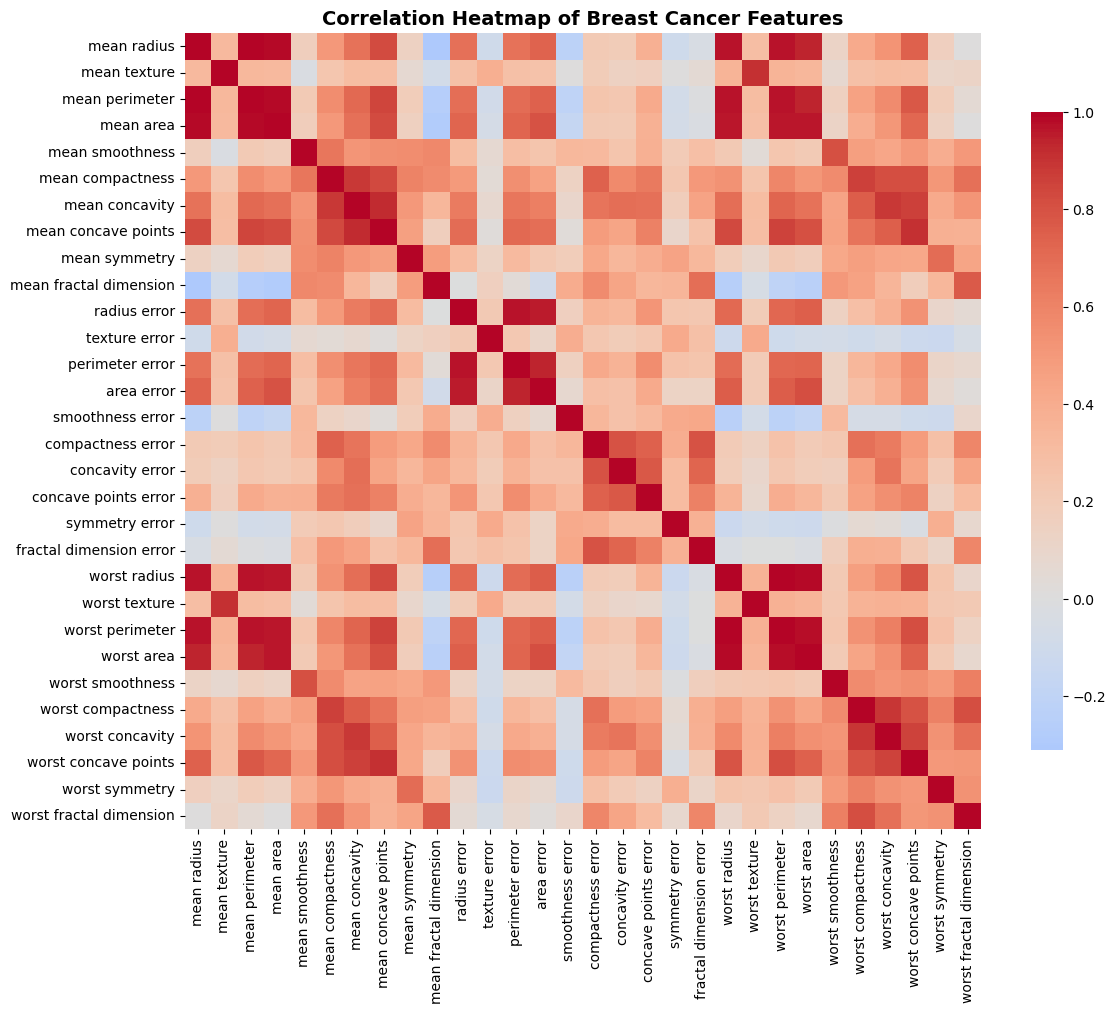

In [15]:
import seaborn as sns
# Compute correlation matrix
corr_matrix = X.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, square=True, cbar_kws={"shrink": 0.8})
plt.title("Correlation Heatmap of Breast Cancer Features", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

In [16]:
# take look at the data
df = X.copy()
df['target'] = y
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


### Standardize the Features

Before applying PCA, we must **standardize the features** because they have **different units and scales**.  
PCA is sensitive to feature magnitude - variables with larger scales can dominate the principal components.

We'll use `StandardScaler` to transform the data so each feature has **mean = 0** and **standard deviation = 1**.  

First, let's use `.describe()` to confirm that features are on different scales.

In [17]:
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


### Your Task: Standardize the Features

Transform X using StandardScaler so each feature has mean=0 and standard deviation=1.

### Your Task: Fit PCA and Find Optimal Number of Components

- Fit PCA on all standardized features.
- Compute cumulative explained variance to find the smallest k where cumulative variance ≥ 95%.

### Your Task: Visualize Cumulative Explained Variance

- Create a plot showing cumulative explained variance versus number of components.
- Add reference lines marking the optimal k and the 95% threshold.

### Your Task: Create Final PCA with Optimal Components

- Create a PCA model with n_components=k_optimal.
- Transform X_scaled to reduce from 30 features to k principal components.

### Your Task: Visualize the First 2 Principal Components

- Create a scatter plot of PC1 vs PC2, colored by diagnosis (malignant=red, benign=blue).
- Observe class separation - good separation indicates PCA retains discriminative information.

### Bonus Task (Optional): Visualize Individual Component Contributions

- Create a bar chart showing variance explained by each of the k components.
- Create a line plot showing cumulative variance across components.
- Observe how the first few components capture most variance.